# HOW TO RETRIEVE AND USE VOLCANO DATA

# ScanDOAS data

## &nbsp;Table of contents
### 1. Basic requirements
### 2. Basic data retrieval and graphing

## &nbsp;1. Basic requirements

### Import required Python modules/libraries

In [1]:
#for querying data
import requests
import json

#pandas for data analysis
import pandas as pd

#matplotlib for graphing
import matplotlib.pyplot as plt

#for getting CSV format data
from io import StringIO

#for system functions
import os

#for date manipulation
import datetime as dt

### Set the source URL

Using [API data endpoint](https://tilde.geonet.org.nz/v4/api-docs/endpoint/data)

In [2]:
#API version 4 data endpoint
source = 'https://tilde.geonet.org.nz/v4/data/'

## &nbsp;2. Basic data retrieval and graphing

We request data on the rate of Sulphur Dioxide (SO$_2$) emissions from a measurement site at Ruapehu.

For all scanDOAS data:
- domain = `scandoas`

The specific parameters are:
  - station = `RUD01`, the station code for one of the scanDOAS stations at Ruapehu
  - name (type of data) = `gasflux`
  - sensorcode = `01`, code for the specific sensor number
  - method (of data collection) = `reviewed`, which means the data have been checked by a person
  - aspect = `SO2`, the type of gas being sensed by the instrument

The resulting `key` specifies the data stream:
  - `scandoas/RUD01/gasflux/01/reviewed/SO2`

Date range:
  - startdate = `2024-01-01`
  - enddate = `2024-09-01`
Instead of providing two dates, the date range can be specified as `latest` followed by a time interval, e.g. `latest/7d` for data from the latest 7 days. The longest time interval is 30 days.

Complete request
- `scandoas/RUD01/gasflux/01/reviewed/SO2/2024-01-01/2024-09-01`

In [3]:
url = source+'scandoas/RUD01/gasflux/01/reviewed/SO2/2024-01-01/2024-09-01'

We will now query the URL and ask for a CSV format to be returned. A 200 response code indicates everything went okay, and the result has been returned (if any).

In [4]:
r = requests.get(url, headers={'Accept':'text/csv'})
print (r)

<Response [200]>


To work with the observation data we will use python's [pandas module](https://pandas.pydata.org/). We will now store the response of our request in a pandas dataframe (`df`), using `pd.read_csv`. By using `parse_dates=['timestamp']` we can convert the 'timestamp' column to a datetime, which makes it easier to work with the data. We add `date_format='ISO8601'` to ensure that pandas uses the full `ISO 8601` datetime format we record our data in. Using `index_col`, we can set the date and time as the index of the dataframe. More information on `pd.read_csv` can be found here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html. We need to use the `StringIO` function with the text returned from our query. By printing the beginning of the result, with `df.head()`, we can see the first 5 lines of the dataframe from our query.

Once we have the data in the dataframe, we can begin to our analysis.

In [5]:
df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], date_format='ISO8601', index_col='timestamp',
                usecols=['timestamp', 'value', 'error'])
df.head()

,value,error
timestamp,,
2024-01-01 00:03:49+00:00,1.83,0.99
2024-01-01 00:08:21+00:00,1.52,0.82
2024-01-01 00:21:51+00:00,1.42,0.77
2024-01-01 01:06:43+00:00,1.47,0.80
2024-01-01 04:01:41+00:00,1.08,0.58


### Data Summary
By using `df.describe()` we can summarise the returned data as this features generates descriptive statistics from dataframes. We can see the number of values (and errors). All the qc values are currently undefined. By default, we also get to see the mean, standard deviation, minimum, maximum, and some percentile values.

In [6]:
df.describe()

,value,error
count,6615.000000,6615.000000
mean,1.670768,0.903610
std,1.333731,0.721311
min,0.000000,0.000000
25%,0.740000,0.400000
50%,1.430000,0.770000
75%,2.340000,1.270000
max,7.870000,4.260000


### Basic Data Plot
By using the value column from our dataframe we are able to produce a basic graph of the SO$_2$ fluxes against time.

Text(0, 0.5, 'sulphur dioxide (SO$_2$) flux (kg/s)')

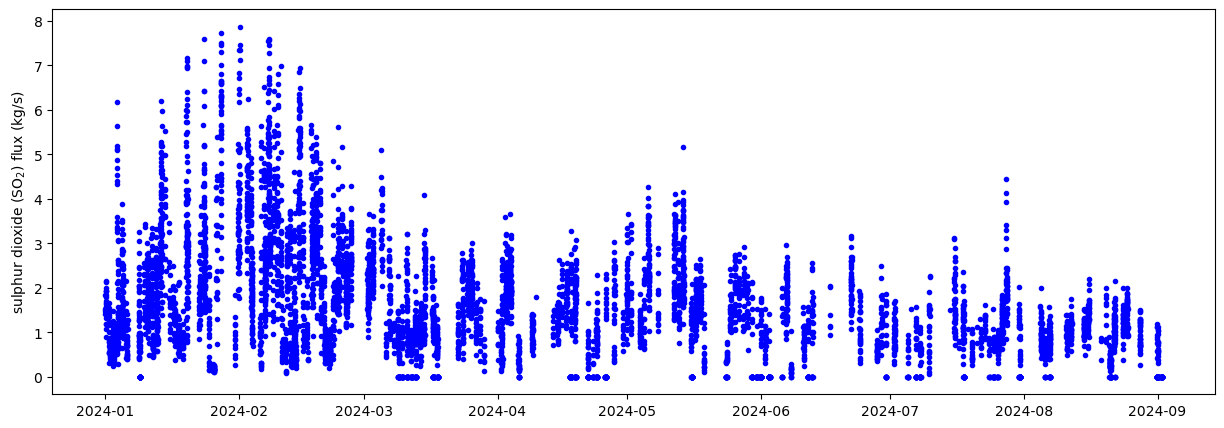

In [7]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df.index, df['value'], color='blue', marker='.', linestyle='None')   
ax.set_ylabel('sulphur dioxide (SO$_2$) flux (kg/s)')

### Observations per day

We can count how many SO$_2$ fluxes observations have been made each day.

In [8]:
count = df.groupby(pd.Grouper(freq='1D')).count()
count.drop('error', axis='columns', inplace=True)
count.rename(columns={'value':'total'}, inplace=True)
count = count[count['total'] != 0]

In [9]:
count.head()

,total
timestamp,
2024-01-01 00:00:00+00:00,40
2024-01-02 00:00:00+00:00,68
2024-01-03 00:00:00+00:00,57
2024-01-04 00:00:00+00:00,46
2024-01-05 00:00:00+00:00,49


#### Graph number of observations

Text(0, 1, 'NUMBER OF OBSERVATIONS EACH DAY')

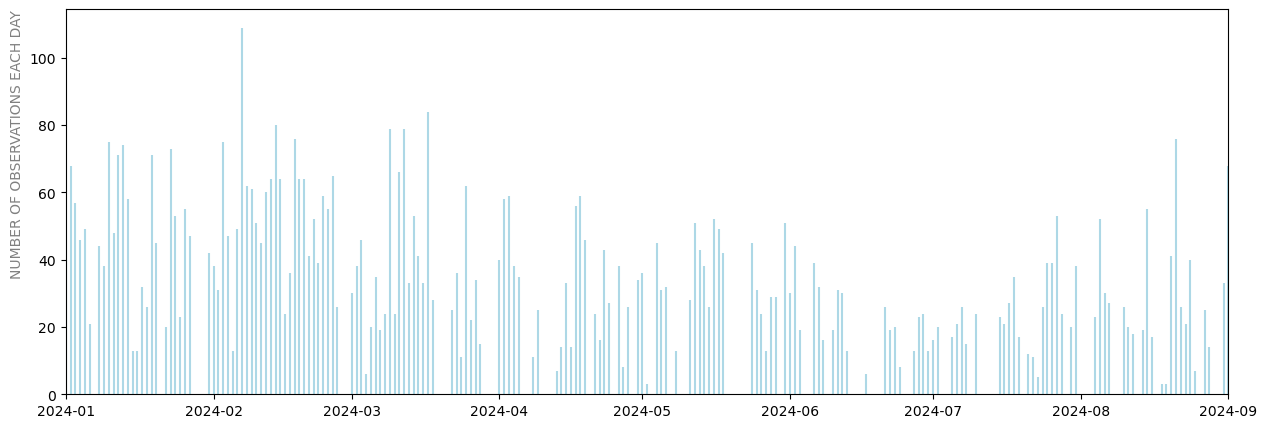

In [10]:
fig,ax = plt.subplots(1,1,figsize=(15,5))

ax.vlines(count.index, 0, count['total'], color='lightblue')
ax.set_xlim(left=dt.datetime(2024,1,1), right=dt.datetime(2024,9,1))
ax.set_ylim(bottom=0)
ax.set_ylabel('NUMBER OF OBSERVATIONS EACH DAY', loc='top', color='grey')

### Mean daily flux

Data aggregation that includes mean daily value can be provided directly by the Tilde API, see `Volcano_data_aggregation.ipynb`. Nonetheless, we show how it can be done by the user, as this enables more aggregation intervals then what is provided by the API.

In [11]:
mean = df.groupby(pd.Grouper(freq='1D')).mean()
mean.drop('error', axis='columns', inplace=True)
mean.rename(columns={'value':'mean'}, inplace=True)

In [12]:
mean.head()

,mean
timestamp,
2024-01-01 00:00:00+00:00,1.368750
2024-01-02 00:00:00+00:00,0.702353
2024-01-03 00:00:00+00:00,2.185789
2024-01-04 00:00:00+00:00,1.809783
2024-01-05 00:00:00+00:00,1.574490


#### Graph of daily mean

Text(0, 1, 'MEAN DAILY FLUX (KG/S)')

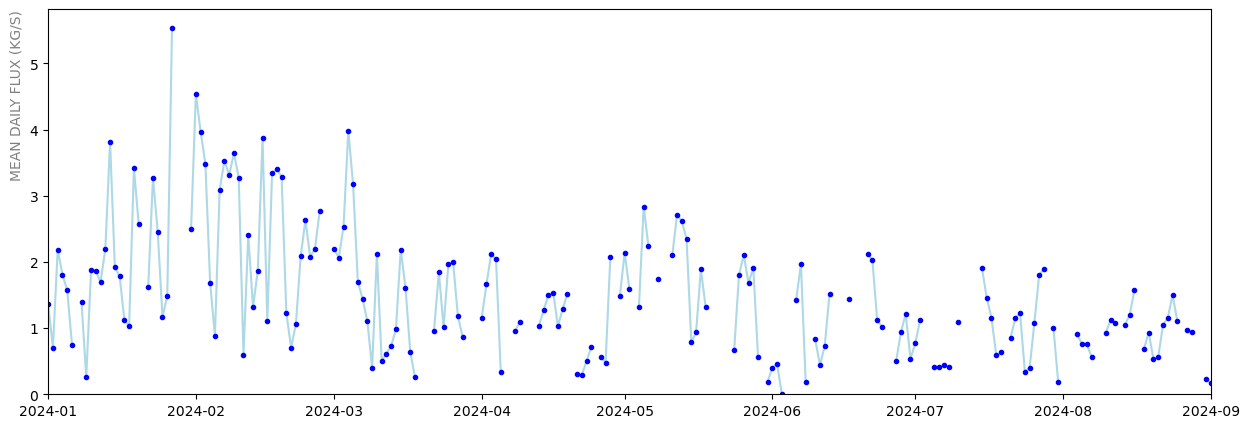

In [13]:
fig,ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(mean.index, mean['mean'], color='lightblue', )
ax.plot(mean.index, mean['mean'], color='blue', marker='.', linestyle='none')
ax.set_xlim(left=dt.datetime(2024,1,1), right=dt.datetime(2024,9,1))
ax.set_ylim(bottom=0)
ax.set_ylabel('MEAN DAILY FLUX (KG/S)', loc='top', color='grey')